# Ungraded Lab: Denoising with a CNN Autoencoder
In the final lab for this week, you will introduce noise to the Fashion MNIST dataset and train an autoencoder to reconstruct the original input images.

https://github.com/sasidhar-programmer/Tensorflow_Advance_Techniques/blob/main/4-Generative-deeplearning-with-tensorflow/week-2/C4_W2_Lab_5_FashionMNIST_NoisyCNNAutoEncoder.ipynb

In [6]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

import numpy as np
import matplotlib.pyplot as plt

In [3]:
def map_image_with_noise(image, label):
    '''normalize the image and generate noisy input'''
    image = tf.cast(image, dtype=tf.float32)
    image = image/255.0
    
    noise_factor = 0.5
    factor = noise_factor * tf.random.normal(shape=image.shape)
    noisy_image = image + factor
    noisy_image = tf.clip_by_value(noisy_image, 0.0, 1.0)
    return noisy_image, image

In [5]:
BATCH_SIZE = 128
SHUFFLE_BUFFER_SIZE = 1024

train_dataset = tfds.load('fashion_mnist', as_supervised=True,
                          split="train")
train_dataset = train_dataset.map(map_image_with_noise)
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE).repeat()

test_dataset = tfds.load('fashion_mnist',
                         as_supervised=True, split="test")
test_dataset = test_dataset.map(map_image_with_noise)
test_dataset = test_dataset.batch(BATCH_SIZE).repeat()

In [20]:
# Exploring the Upsampling operation
a = np.array([
    [0,1],
    [1,0]
])   # a 2x2 gray scale image rows, cols
a = tf.constant(a) 
a = tf.reshape(a, (1,2,2,1)) # reshape it num, rows, cols, channels
print(a)
print("\n upsampling with size 1,2", UpSampling2D(size=(1,2))(a))
print("\n upsampling with size 2,1", UpSampling2D(size=(2,1))(a))

tf.Tensor(
[[[[0]
   [1]]

  [[1]
   [0]]]], shape=(1, 2, 2, 1), dtype=int64)

 upsampling with size 1,2 tf.Tensor(
[[[[0]
   [0]
   [1]
   [1]]

  [[1]
   [1]
   [0]
   [0]]]], shape=(1, 2, 4, 1), dtype=int64)

 upsampling with size 2,1 tf.Tensor(
[[[[0]
   [1]]

  [[0]
   [1]]

  [[1]
   [0]]

  [[1]
   [0]]]], shape=(1, 4, 2, 1), dtype=int64)


In [25]:
# now we build the model

a = 'relu' # activatoin we use most of the time
a2 = 'sigmoid'
k = (3,3)  # kernel size
p = 'same' # padding

def encoder(inputs):
    '''defines the encoder stack'''
    conv1 = Conv2D(filters=64, kernel_size=k,
                   activation=a, padding=p)(inputs)
    maxpool1 = MaxPooling2D(pool_size=(2,2))(conv1)
    
    conv2 = Conv2D(filters=128, kernel_size=k,
                   activation=a, padding=p)(maxpool1)
    maxpool2 = MaxPooling2D(pool_size=(2,2))(conv2)
    
    return maxpool2

def bottleneck(inputs):
    bottleneck = Conv2D(filters=256, kernel_size=k,
                        activation=a, padding=p)(inputs)
    encoder_visualization = Conv2D(filters=1, kernel_size=k,
                                   activation=a2, padding=p)(bottleneck)
    return bottleneck, encoder_visualization


def decoder(inputs):
    '''defines the decoder stack'''

    conv1 = Conv2D(filters=128, kernel_size=k,
                   activation=a, padding=p)(inputs)
    upsample1 = UpSampling2D(size=(2,2))(conv1)
    
    conv2 = Conv2D(filters=64, kernel_size=k,
                   activation=a, padding=p)(upsample1)
    upsample2 = UpSampling2D(size=(2,2))(conv2)
    
    conv3 = Conv2D(filters=1, kernel_size=k,
                   activation=a2, padding=p)(upsample2)
    return conv3


def convolutional_auto_encoder():
    '''builds the entire autoencoder model'''
    inputs = Input(shape=(28, 28,1))
    encoder_stack = encoder(inputs)
    bottleneck_stack, encoder_visualization = bottleneck(encoder_stack)
    decoder_stack = decoder(bottleneck_stack)
    
    model = Model(inputs=inputs, outputs = decoder_stack)
    encoder_model = Model(inputs=inputs, outputs = encoder_visualization)
    
    return model, encoder_model

In [26]:


convolutional_model, convolutional_encoder_model = convolutional_auto_encoder()
convolutional_model.summary()



Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 256)         295168    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 128)         295040

In [28]:
train_steps = 60000 // BATCH_SIZE
valid_steps = 60000 // BATCH_SIZE

convolutional_model.compile(optimizer=Adam(), loss='binary_crossentropy')
conv_model_history = convolutional_model.fit(train_dataset,
                                             steps_per_epoch=train_steps,
                                             validation_data=test_dataset,
                                             validation_steps=valid_steps,
                                             epochs=40)


Epoch 1/40
468/468 [==============================] - 18s 28ms/step - loss: 0.3218 - val_loss: 0.3021
Epoch 2/40
468/468 [==============================] - 13s 26ms/step - loss: 0.2949 - val_loss: 0.2938
Epoch 3/40
468/468 [==============================] - 12s 25ms/step - loss: 0.2905 - val_loss: 0.2915
Epoch 4/40
468/468 [==============================] - 13s 27ms/step - loss: 0.2880 - val_loss: 0.2889
Epoch 5/40
468/468 [==============================] - 12s 25ms/step - loss: 0.2863 - val_loss: 0.2876
Epoch 6/40
468/468 [==============================] - 12s 25ms/step - loss: 0.2850 - val_loss: 0.2867
Epoch 7/40
468/468 [==============================] - 12s 27ms/step - loss: 0.2841 - val_loss: 0.2857
Epoch 8/40
468/468 [==============================] - 12s 26ms/step - loss: 0.2833 - val_loss: 0.2848
Epoch 9/40
468/468 [==============================] - 12s 26ms/step - loss: 0.2827 - val_loss: 0.2845
Epoch 10/40
468/468 [==============================] - 12s 27ms/step - loss: 0.282

In [29]:
def display_one_row(disp_images, offset, shape=(28, 28)):
  '''Display sample outputs in one row.'''
  for idx, noisy_image in enumerate(disp_images):
    plt.subplot(3, 10, offset + idx + 1)
    plt.xticks([])
    plt.yticks([])
    noisy_image = np.reshape(noisy_image, shape)
    plt.imshow(noisy_image, cmap='gray')


def display_results(disp_input_images, disp_encoded, disp_predicted, enc_shape=(8,4)):
  '''Displays the input, encoded, and decoded output values.'''
  plt.figure(figsize=(15, 5))
  display_one_row(disp_input_images, 0, shape=(28,28,))
  display_one_row(disp_encoded, 10, shape=enc_shape)
  display_one_row(disp_predicted, 20, shape=(28,28,))



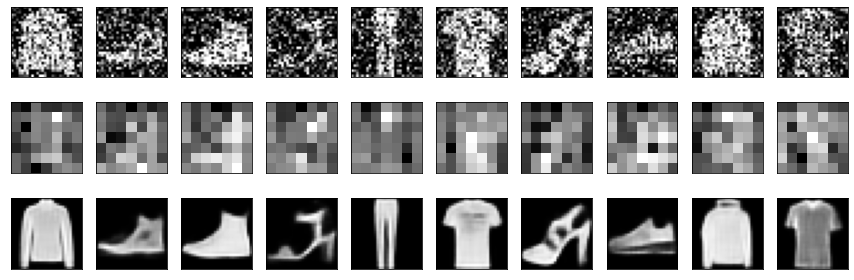

In [30]:


# take 1 batch of the dataset
test_dataset = test_dataset.take(1)

# take the input images and put them in a list
output_samples = []
for input_image, image in tfds.as_numpy(test_dataset):
      output_samples = input_image

# pick 10 indices
idxs = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

# prepare test samples as a batch of 10 images
conv_output_samples = np.array(output_samples[idxs])
conv_output_samples = np.reshape(conv_output_samples, (10, 28, 28, 1))

# get the encoder ouput
encoded = convolutional_encoder_model.predict(conv_output_samples)

# get a prediction for some values in the dataset
predicted = convolutional_model.predict(conv_output_samples)

# display the samples, encodings and decoded values!
display_results(conv_output_samples, encoded, predicted, enc_shape=(7,7))

